In [1]:
import numpy as np
import numpy.random as rnd
from scipy.linalg import expm
from random import sample
import jax.numpy as jnp
from jax import jacobian
import jax
from jax import config
config.update("jax_enable_x64", True)

import scipy
import scipy.linalg as la

import time
import gc
import matplotlib.pyplot as plt
plt.rcParams.update({'axes.titlesize': 20,    # Font size of the axes title
                     'axes.labelsize': 20,    # Font size of the x and y labels
                     'xtick.labelsize': 16,   # Font size of the tick labels
                     'ytick.labelsize': 16,   # Font size of the tick labels
                     'legend.fontsize': 16    # Font size of the legend
                    })

$\textbf{Auxiliary Functions:}$

In [2]:
def cart_pole_dynamics(state, control, m_c = 1.0, m_p = 1.0, l = 1.0, g = 1.0):
    """
    Compute the continuous-time dynamics of the cart-pole system.

    Parameters:
    state (array): The state vector [x, x_dot, theta, theta_dot].
    control (array): The control vector [F], where F is the force applied to the cart.

    Returns:
    array: The derivative of the state vector [x_dot, x_ddot, theta_dot, theta_ddot].
    """
    # Unpack the state vector
    x, x_dot, theta, theta_dot = state

    # Unpack the control vector
    F = control[0]

    # Intermediate calculations
    sin_theta = jnp.sin(theta)
    cos_theta = jnp.cos(theta)
    total_mass = m_c + m_p
    d = total_mass * l - m_p * l * cos_theta**2

    a1 = jnp.array([[m_c + m_p, m_p*l*cos_theta], [m_p*cos_theta, m_p*l]])
    b1 = jnp.array([[m_p*l*theta_dot**2+F], [m_p*g*sin_theta]])
    c1 = jnp.linalg.inv(a1)@b1
    x_ddot = c1[0,0]
    theta_ddot = c1[1,0]
    return jnp.array([x_dot, x_ddot, theta_dot, theta_ddot])


def subspace_distance(Phi_1,Phi_2):
    distance = la.norm(Phi_1.T@Phi_2, ord = 2)
    return distance

def LQR(A,B,Q=None, R=None):
    if not Q:
        Q = np.eye(B.shape[0])
    if not R:
        R = np.eye(B.shape[1])
    P = la.solve_discrete_are(A,B,Q,R)
    return -la.inv(B.T@P@B+R)@B.T@P@A

$\textbf{Generate multiple tasks:}$

In [3]:
H = 500 #Number of tasks

#System dimensions
dx = 4
du = 1

#Linearize the cartpole system around the origin
x_0 = np.zeros(4)
u_0 = np.array([0.0])

dt = 0.25
g = 1.0


params_nominal = [(0.4, 1.0, 1.0), (1.6, 1.3, 0.3), (1.3, 0.7, 0.65), (0.2, 0.055, 1.36), (0.2, 0.47, 1.825)]

nsys = len(params_nominal)

params = []
l=0
for i in range(H):
    if i%nsys == 0:
        l=0
    params.append(params_nominal[l])
    l+=1

for i in range(nsys,H):
    params[i] = tuple(np.array(params[i]) + 0.001*np.random.rand(1,3)[0])

In [4]:
#Setting the same cost matrices for all tasks
Q = np.diag(np.array([1,1,1,1]))
R = np.eye(1)
            
dynamics = []
K_star_tasks = []
K0_tasks = []
for param in params:
    m_c, m_p, ell = param
    Atemp = np.eye(4) + dt*np.array(jacobian(cart_pole_dynamics, 0)(x_0, u_0, m_c , m_p, ell, g=1.0))
    Atemp = 0.99*Atemp/np.max(np.abs(la.eigvals(Atemp)))
    Btemp = dt*np.array(jacobian(cart_pole_dynamics, 1)(x_0, u_0, m_c, m_p, ell, g=1.0))
    #Computing the optimal controller for each generated cartpole system  
    K_star_tasks.append(LQR(Atemp,Btemp))
    #Scaling the task optimal controller to obtain a suboptimal initial controller
    K0_tasks.append(0.8*K_star_tasks[-1])
    dynamics.append((Atemp,Btemp))
    #Checking if K0h stabilizes the generated task
    assert np.max(np.abs(la.eigvals(Atemp+np.outer(Btemp,K0_tasks[-1])))) < 0.999


#Generating the ground truth representation Phi_star
A1, B1 = dynamics[0]
Atemp = np.copy(A1); Btemp = np.copy(B1)

bases = np.zeros((20,0))
for i in range(5):
    ei = np.eye(4,1,-i)
    Atemp[1,2] = ei[0]; Atemp[3,2] = ei[1]; Btemp[1,0] = ei[2]; Btemp[3,0] = ei[3]
    basis = np.vstack([Atemp.T, Btemp.T]).flatten()
    bases = np.hstack([bases, np.expand_dims(basis,1)])


U, S, Vh = la.svd(bases)
Phi_star = U[:,:bases.shape[1]]
Phi_star_perp = U[:,bases.shape[1]:]

$\textbf{Auxiliary Functions:}$

In [5]:
def state_update(x,u,w,A,B):
    
    return (A@x.T + B@u.T + np.sqrt(1)*w.T).T

def get_input(x, K, K_0, v, abort):
    
    N = x.shape[0]
    abort = abort.reshape(N,1)
    u = jnp.sum((abort*K_0 + (1-abort)*K)*x, axis=1) + (v*(1-abort)).squeeze()
    return u.reshape(N,1)


def step(carry, noise):
    
    x, abort, K, K_0, sigma, cost, zszs, zsxs, x_b, K_b, A, B = carry

    abort = jnp.maximum(abort, jnp.maximum(jnp.linalg.norm(x, axis=1) >= x_b, jnp.linalg.norm(K, axis=1) >= K_b))
    
    #process and input noise
    
    w = noise[:,:-1]; v = sigma*noise[:,-1:]

    u = get_input(x, K, K_0, v, abort)
    
    xnext = state_update(x,u,w,A,B)

    cost += jnp.linalg.norm(x, axis=1)**2 + jnp.linalg.norm(u,axis=1)**2

    z = jnp.hstack([x, u])
    zszs += jnp.expand_dims(z, axis = 1)*jnp.expand_dims(z, axis = 2)
    zsxs += (jnp.expand_dims(z, axis = 2)*jnp.expand_dims(xnext, axis = 1)).reshape(x.shape[0],20)

    carry = (xnext, abort, K, K_0, sigma, cost, zszs, zsxs, x_b, K_b, A, B)
    
    return carry, ()


def LS(Phi,  zszs, zsxs):
    Lambda = Phi.T@np.kron(zszs, np.eye(4))@Phi
    evals = la.eigvals(Lambda)
    #assert np.min(np.abs(evals)) > 1e-8, f"minimum eigevalue is: {np.min(np.abs(evals))} and all the eigenvalues are {evals}"
    H = Phi.T@zsxs
    theta = la.inv(Lambda)@H

    dyn_matrices = (Phi@theta).reshape(5, 4, order='C')
    return dyn_matrices[:4].T, dyn_matrices[4:].T



def LS_DFW_1(Phi,  zszs, zsxs):
    Lambda = Phi.T@np.kron(zszs, np.eye(4))@Phi
    evals = la.eigvals(Lambda)
    #assert np.min(np.abs(evals)) > 1e-8, f"minimum eigevalue is: {np.min(np.abs(evals))} and all the eigenvalues are {evals}"
    H = Phi.T@zsxs
    theta = la.inv(Lambda)@H
    return theta

def LS_DFW_2(zszs, zsxs):
    Lambda = np.kron(zszs, np.eye(4))
    evals = la.eigvals(Lambda)
    #assert np.min(np.abs(evals)) > 1e-8, f"minimum eigevalue is: {np.min(np.abs(evals))} and all the eigenvalues are {evals}"
    H = zsxs
    theta = la.inv(Lambda)@H
    return theta


def DFW(Phi_hat, DFW_N, eta, H, zszs1, zsxs1, zszs2, zsxs2, Phi_star_perp):
    
    N = len(Phi_hat)
    
    for i in range(N):
    
        Phi = []
        thetas = []


        zszsh1=[]; zsxsh1=[]; zszsh2=[]; zsxsh2=[]
        
        for h in range(H):
            zszsh1.append(zszs1[h][i])
            zszsh2.append(zszs2[h][i])
            zsxsh1.append(zsxs1[h][i])
            zsxsh2.append(zsxs2[h][i])

        for n in range(DFW_N):

            thetas = np.zeros((0, 5))
            lstsq_sols_hs = np.zeros((0,20))

            for h in range(H):

                theta_h = LS_DFW_1(Phi_hat[i],  zszsh1[h], zsxsh1[h])
                lstsq_sol_h = LS_DFW_2(zszsh2[h], zsxsh2[h])
                thetas = np.vstack([thetas, np.expand_dims(theta_h,0)])
                lstsq_sols_hs = np.vstack([lstsq_sols_hs, np.expand_dims(lstsq_sol_h,0)])
                
            grad_Phi = (thetas.T@(thetas@Phi_hat[i].T - lstsq_sols_hs)).T
            Phi_hat[i]= Phi_hat[i] - (eta/H)*grad_Phi

            #Get a orthonormal representation
            Phi_hat[i] = la.svd(Phi_hat[i],False)[0]

    return Phi_hat

def play_controller(init,all_noise):
    carry, _ = jax.lax.scan(step, init, all_noise)
    return carry[0], carry[1], carry[5], carry[6], carry[7]

$\textbf{Shared Representation Certainty Equivalent Control with Continual Exploration:}$

In [6]:
def adaptive_control(Phi_0, Phi_star_perp, K0_tasks, tau_1, x_b, K_b, dx, du, exploration_sequence, DFW_N, H, dynamics, Q, R, eta, N, key):
    
  
    kfin = len(exploration_sequence) #number of epochs
    
    
    
    tau_ = 0
    tau = tau_1 #Initial epoch length
    
    
    abort = jnp.zeros(N)
    cost = jnp.zeros(N)
    x = jnp.zeros((N, 4))
    
    
    aborth = []
    K_0h = []
    Kh =[] 
    costh = []
    xh = []
    
    for h in range(H):
        aborth.append(abort)
        K_0h.append(jnp.stack([K0_tasks[h].squeeze()]*N))
        Kh.append(jnp.stack([K0_tasks[h].squeeze()]*N))
        costh.append(cost)
        xh.append(x)
        
        
    #Representation 
    Phi_hat = []
    for i in range(N):
        Phi_hat.append(Phi_0)
        
    T = 0

    costs = []
    times = []

    costs.append(costh[0]) #We will evaluate the cost of the first task 
    times.append(T)
    
    
    key, subkey = jax.random.split(key)
    
    for k in range(kfin):
        start_time = time.time()
        
        zszs = jnp.zeros((N, dx+du, dx+du))
        zsxs = jnp.zeros((N, dx*(dx+du)))
        
        zszsh = []
        zsxsh = []
        for h in range(H):
            zszsh.append(zszs)
            zsxsh.append(zsxs)
            
        
        zszsh1 = zszsh; zsxsh1 = zsxsh
        zszsh2 = zszsh; zsxsh2 = zsxsh
        zszsh3 = zszsh; zsxsh3 = zsxsh
        
    
        timestep = 0
        while timestep < tau - tau_:
            temp = min(1000, tau-tau_ - timestep)
            timestep += temp

            T += temp
            
            #Split the data for the DFW and LS
            temp1 = int(3*temp/8); temp2 = int(3*temp/8); temp3 = int(temp/4)

            for h in range(H):
                
            
                key, subkey = jax.random.split(subkey)
                
                all_noise1 = jax.random.normal(key, (temp1, N, 5))
                init1 = (xh[h], aborth[h], Kh[h], K_0h[h], jnp.sqrt(exploration_sequence[k]), costh[h], zszsh1[h], zsxsh1[h], x_b, K_b, dynamics[h][0], dynamics[h][1])
                xh[h], aborth[h], costh[h], zszsh1[h], zsxsh1[h] = play_controller(init1,all_noise1)
                
                
                key, subkey = jax.random.split(subkey)
                
                all_noise2 = jax.random.normal(key, (temp2, N, 5))
                init2 = (xh[h], aborth[h], Kh[h], K_0h[h], jnp.sqrt(exploration_sequence[k]), costh[h], zszsh2[h], zsxsh2[h], x_b, K_b, dynamics[h][0], dynamics[h][1])
                xh[h], aborth[h], costh[h], zszsh2[h], zsxsh2[h] = play_controller(init2,all_noise2)
                
               
                key, subkey = jax.random.split(subkey)
                
                all_noise3 = jax.random.normal(key, (temp3, N, 5))
                init3 = (xh[h], aborth[h], Kh[h], K_0h[h], jnp.sqrt(exploration_sequence[k]), costh[h], zszsh3[h], zsxsh3[h], x_b, K_b, dynamics[h][0], dynamics[h][1])
                xh[h], aborth[h], costh[h], zszsh3[h], zsxsh3[h] = play_controller(init3,all_noise3)
    
            #free up memory
            gc.collect()
                

            costs.append(costh[0])
            times.append(T)

            
            
        
        Phi_hat = DFW(Phi_hat, DFW_N, eta, H, zszsh1, zsxsh1, zszsh2, zsxsh2, Phi_star_perp)  
        
        
        average_dist_error = 0
        
        for i in range(N):
            average_dist_error+= subspace_distance(Phi_hat[i],Phi_star_perp)
            
        average_est_error = 0 #for the first task
        Kh = []
      
        for h in range(H):
            K = []
            for i in range(N):
                if not aborth[h][i]:
                    
                    Ahat_h , Bhat_h  = LS(Phi_hat[i],  np.array(zszsh3[h][i]), np.array(zsxsh3[h][i]))
                    
                    end_time = time.time()
                    
                    if h == 0:
                        average_est_error +=  la.norm(Ahat_h - dynamics[0][0], 'fro')**2 + la.norm(Bhat_h - dynamics[0][1], 'fro')**2
                    Knew = LQR(Ahat_h,Bhat_h)
  
                else:
                    Knew = K_0h[h][i]
                
                K.append(Knew.squeeze())
            
            K = np.stack(K)
            
            Kh.append(K)
            
        
        end_time = time.time()
        
        
        
        print(f"dist error: {round(average_dist_error/N,3)}, est error: {round(average_est_error/N,5)}, cost: {int(jnp.mean(costh[0]))}")

        tau_ = tau
        tau = 2*tau

    return costs, times

In [8]:
def adaptive_control_no_DFW(Phi_0, Phi_star_perp, K0_tasks, tau_1, x_b, K_b, dx, du, exploration_sequence, H, dynamics, Q, R, N, key):
    
    kfin = len(exploration_sequence) #number of epochs

    tau_ = 0
    tau = tau_1 #Initial epoch length
    
    
    abort = jnp.zeros(N)
    cost = jnp.zeros(N)
    x = jnp.zeros((N, 4))
    
    
    aborth = []
    K_0h = []
    Kh =[] 
    costh = []
    xh = []
    
    for h in range(H):
        aborth.append(abort)
        K_0h.append(jnp.stack([K0_tasks[h].squeeze()]*N))
        Kh.append(jnp.stack([K0_tasks[h].squeeze()]*N))
        costh.append(cost)
        xh.append(x)
        
        
    #Representation 
    Phi_hat = []
    for i in range(N):
        Phi_hat.append(Phi_0)
        
    T = 0

    costs = []
    times = []

    costs.append(costh[0]) #We will evaluate the cost of the first task 
    times.append(T)
    
    #key = jax.random.PRNGKey(0)
    key, subkey = jax.random.split(key)
    
    for k in range(kfin):
        start_time = time.time()
        
        zszs = jnp.zeros((N, dx+du, dx+du))
        zsxs = jnp.zeros((N, dx*(dx+du)))
        
        zszsh = []
        zsxsh = []
        for h in range(H):
            zszsh.append(zszs)
            zsxsh.append(zsxs)
            
        
        zszsh1 = zszsh; zsxsh1 = zsxsh
        zszsh2 = zszsh; zsxsh2 = zsxsh
        zszsh3 = zszsh; zsxsh3 = zsxsh
        
    
        timestep = 0
        while timestep < tau - tau_:
            temp = min(1000, tau-tau_ - timestep)
            timestep += temp

            T += temp
            
           

            for h in range(H):
                
            
                key, subkey = jax.random.split(subkey)
                
                all_noise1 = jax.random.normal(key, (temp, N, 5))
                init1 = (xh[h], aborth[h], Kh[h], K_0h[h], jnp.sqrt(exploration_sequence[k]), costh[h], zszsh[h], zsxsh[h], x_b, K_b, dynamics[h][0], dynamics[h][1])
                xh[h], aborth[h], costh[h], zszsh[h], zsxsh[h] = play_controller(init1,all_noise1)

            #free up memory
            gc.collect()
                

            costs.append(costh[0])
            times.append(T)

            
        average_dist_error = 0
        
        for i in range(N):
            average_dist_error+= subspace_distance(Phi_hat[i],Phi_star_perp)
            
        average_est_error = 0 #for the first task
        Kh = []
        for h in range(H):
            K = []
            for i in range(N):
                if not aborth[h][i]:
                    
                    Ahat_h , Bhat_h  = LS(Phi_hat[i],  np.array(zszsh[h][i]), np.array(zsxsh[h][i]))
                    
                    end_time = time.time()
                   
                    if h == 0:
                        average_est_error +=  la.norm(Ahat_h - dynamics[0][0], 'fro')**2 + la.norm(Bhat_h - dynamics[0][1], 'fro')**2
                    Knew = LQR(Ahat_h,Bhat_h)
  
                else:
                    Knew = K_0h[h][i]
                
                K.append(Knew.squeeze())
            
            K = np.stack(K)
            
            Kh.append(K)
            
        
        end_time = time.time()
        
        if k == kfin-1:
            print(f"dist error: {round(average_dist_error/N,3)}, est error: {round(average_est_error/N,5)}, cost: {int(jnp.mean(costh[0]))}")

        tau_ = tau
        tau = 2*tau

    return costs, times

$\textbf{Algorithm parameters:}$

In [9]:
#Algorithm parameters

#Initialization for the representation and task weights

x_b = 25 #state bound
K_b = 15 #controller bound
tau_1 = 30 #initial epoch length
kfin = 10 #number of epochs
exploration_sequence = [1.3/(jnp.sqrt(2**k)) for k in range(kfin)]
key_noise = jax.random.PRNGKey(0)

$\textbf{Learning the system matrices (A, B) from scratch}:$

In [10]:
N = 1000

Phi_0 = np.eye(dx*(dx+du))
costs = []
key, subkey = jax.random.split(key_noise)
for i in range(N):
    start_time = time.time()
    key, subkey = jax.random.split(subkey)
    cost_temp, times = adaptive_control_no_DFW(Phi_0, Phi_star_perp, K0_tasks, tau_1, x_b, K_b, dx, du, exploration_sequence, 1, dynamics, Q, R, 1, subkey)
    costs.append(cost_temp)
    end_time = time.time()
    print(f"Trial: {i}, time: {end_time - start_time}")

costs_temp = np.zeros((len(times),N))
for i in range(len(times)):
    for j in range(N):
        costs_temp[i,j] = np.array(costs[j][i])[0]
        
P = la.solve_discrete_are(dynamics[0][0],dynamics[0][1],Q,R)
regret = [cost - 1*T*np.trace(P) for (cost,T) in zip(costs_temp,times)]
regret_single = np.zeros((len(regret),N))

for i in range(len(regret)):
    for j in range(N):
        regret_single[i,j] = np.array(regret[i])[j]

dist error: 1.0, est error: 0.02319, cost: 140673
Trial: 0, time: 1.7964227199554443
dist error: 1.0, est error: 0.01008, cost: 139636
Trial: 1, time: 0.6083638668060303
dist error: 1.0, est error: 0.00872, cost: 140047
Trial: 2, time: 0.5725791454315186
dist error: 1.0, est error: 0.00682, cost: 139200
Trial: 3, time: 0.5884139537811279
dist error: 1.0, est error: 0.02081, cost: 141810
Trial: 4, time: 0.5992848873138428
dist error: 1.0, est error: 0.03229, cost: 140685
Trial: 5, time: 0.6048669815063477
dist error: 1.0, est error: 0.02233, cost: 139694
Trial: 6, time: 0.5593063831329346
dist error: 1.0, est error: 0.0271, cost: 148351
Trial: 7, time: 0.5453791618347168
dist error: 1.0, est error: 0.01398, cost: 140540
Trial: 8, time: 0.5584008693695068
dist error: 1.0, est error: 0.01872, cost: 141098
Trial: 9, time: 0.5915567874908447
dist error: 1.0, est error: 0.01434, cost: 140996
Trial: 10, time: 0.6041810512542725
dist error: 1.0, est error: 0.01473, cost: 142710
Trial: 11, time

dist error: 1.0, est error: 0.01223, cost: 138505
Trial: 96, time: 0.6770973205566406
dist error: 1.0, est error: 0.00706, cost: 140211
Trial: 97, time: 0.6497719287872314
dist error: 1.0, est error: 0.01274, cost: 140299
Trial: 98, time: 0.6750407218933105
dist error: 1.0, est error: 0.00534, cost: 140776
Trial: 99, time: 0.6169748306274414
dist error: 1.0, est error: 0.01121, cost: 144474
Trial: 100, time: 0.6055848598480225
dist error: 1.0, est error: 0.00462, cost: 141836
Trial: 101, time: 0.7001237869262695
dist error: 1.0, est error: 0.01813, cost: 139588
Trial: 102, time: 0.6958069801330566
dist error: 1.0, est error: 0.01251, cost: 140990
Trial: 103, time: 0.6614100933074951
dist error: 1.0, est error: 0.02106, cost: 140614
Trial: 104, time: 0.6512439250946045
dist error: 1.0, est error: 0.02159, cost: 139727
Trial: 105, time: 0.6854503154754639
dist error: 1.0, est error: 0.03876, cost: 142259
Trial: 106, time: 0.6643478870391846
dist error: 1.0, est error: 0.05066, cost: 1419

dist error: 1.0, est error: 0.01253, cost: 140566
Trial: 191, time: 0.6228048801422119
dist error: 1.0, est error: 0.03993, cost: 137422
Trial: 192, time: 0.622556209564209
dist error: 1.0, est error: 0.0205, cost: 140752
Trial: 193, time: 0.6801049709320068
dist error: 1.0, est error: 0.00967, cost: 137291
Trial: 194, time: 0.6717269420623779
dist error: 1.0, est error: 0.0102, cost: 138797
Trial: 195, time: 0.6675629615783691
dist error: 1.0, est error: 0.01839, cost: 137561
Trial: 196, time: 0.6401357650756836
dist error: 1.0, est error: 0.01494, cost: 137603
Trial: 197, time: 0.6691288948059082
dist error: 1.0, est error: 0.01046, cost: 138774
Trial: 198, time: 0.6637430191040039
dist error: 1.0, est error: 0.00757, cost: 139160
Trial: 199, time: 0.6443042755126953
dist error: 1.0, est error: 0.00472, cost: 140071
Trial: 200, time: 0.6758029460906982
dist error: 1.0, est error: 0.0087, cost: 137422
Trial: 201, time: 0.6716160774230957
dist error: 1.0, est error: 0.01257, cost: 1415

dist error: 1.0, est error: 0.00606, cost: 142748
Trial: 286, time: 0.7303762435913086
dist error: 1.0, est error: 0.00281, cost: 143656
Trial: 287, time: 0.6997859477996826
dist error: 1.0, est error: 0.01455, cost: 143378
Trial: 288, time: 0.6751580238342285
dist error: 1.0, est error: 0.00293, cost: 142615
Trial: 289, time: 0.6743950843811035
dist error: 1.0, est error: 0.00937, cost: 140912
Trial: 290, time: 0.6811671257019043
dist error: 1.0, est error: 0.01461, cost: 142191
Trial: 291, time: 0.6738979816436768
dist error: 1.0, est error: 0.02014, cost: 139281
Trial: 292, time: 0.6732089519500732
dist error: 1.0, est error: 0.01215, cost: 140169
Trial: 293, time: 0.662039041519165
dist error: 1.0, est error: 0.01881, cost: 137376
Trial: 294, time: 0.6818702220916748
dist error: 1.0, est error: 0.01831, cost: 138480
Trial: 295, time: 0.6677889823913574
dist error: 1.0, est error: 0.01136, cost: 138196
Trial: 296, time: 0.6753909587860107
dist error: 1.0, est error: 0.01624, cost: 1

dist error: 1.0, est error: 0.0123, cost: 138469
Trial: 381, time: 0.7468559741973877
dist error: 1.0, est error: 0.00975, cost: 139131
Trial: 382, time: 0.6951491832733154
dist error: 1.0, est error: 0.01938, cost: 140886
Trial: 383, time: 0.748305082321167
dist error: 1.0, est error: 0.02238, cost: 138357
Trial: 384, time: 0.7096042633056641
dist error: 1.0, est error: 0.02522, cost: 139016
Trial: 385, time: 0.7100028991699219
dist error: 1.0, est error: 0.02364, cost: 141291
Trial: 386, time: 0.7100040912628174
dist error: 1.0, est error: 0.01685, cost: 143417
Trial: 387, time: 0.7378191947937012
dist error: 1.0, est error: 0.02952, cost: 147129
Trial: 388, time: 0.7111260890960693
dist error: 1.0, est error: 0.01549, cost: 143310
Trial: 389, time: 0.6936588287353516
dist error: 1.0, est error: 0.00297, cost: 141897
Trial: 390, time: 0.7412409782409668
dist error: 1.0, est error: 0.00217, cost: 142578
Trial: 391, time: 0.711097002029419
dist error: 1.0, est error: 0.0116, cost: 1388

dist error: 1.0, est error: 0.00887, cost: 143704
Trial: 476, time: 0.6119589805603027
dist error: 1.0, est error: 0.01627, cost: 141984
Trial: 477, time: 0.610098123550415
dist error: 1.0, est error: 0.02138, cost: 142329
Trial: 478, time: 0.6000990867614746
dist error: 1.0, est error: 0.02622, cost: 143946
Trial: 479, time: 0.6086699962615967
dist error: 1.0, est error: 0.02397, cost: 141174
Trial: 480, time: 0.614063024520874
dist error: 1.0, est error: 0.03263, cost: 140553
Trial: 481, time: 0.6385791301727295
dist error: 1.0, est error: 0.02798, cost: 141117
Trial: 482, time: 0.6855170726776123
dist error: 1.0, est error: 0.01748, cost: 141914
Trial: 483, time: 0.6322848796844482
dist error: 1.0, est error: 0.01308, cost: 142524
Trial: 484, time: 0.6707179546356201
dist error: 1.0, est error: 0.02319, cost: 143166
Trial: 485, time: 0.5951390266418457
dist error: 1.0, est error: 0.01615, cost: 141362
Trial: 486, time: 0.6463413238525391
dist error: 1.0, est error: 0.00927, cost: 14

dist error: 1.0, est error: 0.0363, cost: 139510
Trial: 571, time: 0.6287767887115479
dist error: 1.0, est error: 0.0159, cost: 142755
Trial: 572, time: 0.6390259265899658
dist error: 1.0, est error: 0.01808, cost: 141154
Trial: 573, time: 0.6250307559967041
dist error: 1.0, est error: 0.00926, cost: 141242
Trial: 574, time: 0.6830449104309082
dist error: 1.0, est error: 0.00444, cost: 141202
Trial: 575, time: 0.634619951248169
dist error: 1.0, est error: 0.00644, cost: 139980
Trial: 576, time: 0.6462531089782715
dist error: 1.0, est error: 0.01181, cost: 140634
Trial: 577, time: 0.6957218647003174
dist error: 1.0, est error: 0.01132, cost: 141522
Trial: 578, time: 0.6955268383026123
dist error: 1.0, est error: 0.01794, cost: 140890
Trial: 579, time: 0.667492151260376
dist error: 1.0, est error: 0.01495, cost: 138218
Trial: 580, time: 0.6269021034240723
dist error: 1.0, est error: 0.03482, cost: 139319
Trial: 581, time: 0.6229708194732666
dist error: 1.0, est error: 0.02372, cost: 1391

dist error: 1.0, est error: 0.02666, cost: 140756
Trial: 666, time: 0.7331807613372803
dist error: 1.0, est error: 0.01209, cost: 140384
Trial: 667, time: 0.7657012939453125
dist error: 1.0, est error: 0.00989, cost: 140345
Trial: 668, time: 0.7309670448303223
dist error: 1.0, est error: 0.03123, cost: 139973
Trial: 669, time: 0.7103838920593262
dist error: 1.0, est error: 0.01689, cost: 140393
Trial: 670, time: 0.6971969604492188
dist error: 1.0, est error: 0.01434, cost: 140274
Trial: 671, time: 0.7636430263519287
dist error: 1.0, est error: 0.0362, cost: 139383
Trial: 672, time: 0.7125217914581299
dist error: 1.0, est error: 0.0143, cost: 140318
Trial: 673, time: 0.7015323638916016
dist error: 1.0, est error: 0.00932, cost: 138428
Trial: 674, time: 0.7137398719787598
dist error: 1.0, est error: 0.02988, cost: 141846
Trial: 675, time: 0.6854090690612793
dist error: 1.0, est error: 0.01965, cost: 142356
Trial: 676, time: 0.7495181560516357
dist error: 1.0, est error: 0.01351, cost: 14

dist error: 1.0, est error: 0.02538, cost: 137668
Trial: 761, time: 0.754979133605957
dist error: 1.0, est error: 0.03876, cost: 137477
Trial: 762, time: 0.7532317638397217
dist error: 1.0, est error: 0.03135, cost: 141344
Trial: 763, time: 0.7147927284240723
dist error: 1.0, est error: 0.00918, cost: 138701
Trial: 764, time: 0.6941807270050049
dist error: 1.0, est error: 0.02243, cost: 140444
Trial: 765, time: 0.7402729988098145
dist error: 1.0, est error: 0.00981, cost: 140205
Trial: 766, time: 0.6629128456115723
dist error: 1.0, est error: 0.02214, cost: 138976
Trial: 767, time: 0.6981308460235596
dist error: 1.0, est error: 0.01293, cost: 138197
Trial: 768, time: 0.7115640640258789
dist error: 1.0, est error: 0.02832, cost: 139716
Trial: 769, time: 0.7610201835632324
dist error: 1.0, est error: 0.01037, cost: 138656
Trial: 770, time: 0.735198974609375
dist error: 1.0, est error: 0.02988, cost: 138751
Trial: 771, time: 0.6408970355987549
dist error: 1.0, est error: 0.03009, cost: 13

dist error: 1.0, est error: 0.01075, cost: 143588
Trial: 856, time: 0.6411492824554443
dist error: 1.0, est error: 0.02456, cost: 140291
Trial: 857, time: 0.7042620182037354
dist error: 1.0, est error: 0.02613, cost: 139606
Trial: 858, time: 0.6714880466461182
dist error: 1.0, est error: 0.02309, cost: 139467
Trial: 859, time: 0.7117099761962891
dist error: 1.0, est error: 0.01413, cost: 140866
Trial: 860, time: 0.6618320941925049
dist error: 1.0, est error: 0.00942, cost: 140791
Trial: 861, time: 0.6424400806427002
dist error: 1.0, est error: 0.01843, cost: 139549
Trial: 862, time: 0.6497828960418701
dist error: 1.0, est error: 0.02256, cost: 138616
Trial: 863, time: 0.6410548686981201
dist error: 1.0, est error: 0.03399, cost: 139570
Trial: 864, time: 0.6424391269683838
dist error: 1.0, est error: 0.02595, cost: 141479
Trial: 865, time: 0.6572308540344238
dist error: 1.0, est error: 0.0171, cost: 139195
Trial: 866, time: 0.6411850452423096
dist error: 1.0, est error: 0.01806, cost: 1

dist error: 1.0, est error: 0.00827, cost: 138851
Trial: 951, time: 0.7240231037139893
dist error: 1.0, est error: 0.02482, cost: 137464
Trial: 952, time: 0.7363190650939941
dist error: 1.0, est error: 0.02816, cost: 138964
Trial: 953, time: 0.7394256591796875
dist error: 1.0, est error: 0.01528, cost: 136529
Trial: 954, time: 0.779991865158081
dist error: 1.0, est error: 0.01864, cost: 138118
Trial: 955, time: 0.7135300636291504
dist error: 1.0, est error: 0.02285, cost: 136845
Trial: 956, time: 0.7147510051727295
dist error: 1.0, est error: 0.02067, cost: 139226
Trial: 957, time: 0.7239482402801514
dist error: 1.0, est error: 0.01924, cost: 136883
Trial: 958, time: 0.7455470561981201
dist error: 1.0, est error: 0.00494, cost: 136224
Trial: 959, time: 0.6854567527770996
dist error: 1.0, est error: 0.00797, cost: 140282
Trial: 960, time: 0.7281279563903809
dist error: 1.0, est error: 0.00729, cost: 142682
Trial: 961, time: 0.6579949855804443
dist error: 1.0, est error: 0.01381, cost: 1

In [16]:
#Initial representation
init_dist = 0.99
Phi_0 = np.copy(Phi_star)
Phi_0[:,-1] = Phi_0[:,-1] + np.sqrt(1/(1/init_dist**2 - 1))*Phi_star_perp[:,0]
Phi_0[:,-1] = Phi_0[:,-1]/la.norm(Phi_0[:,-1])

$\textbf{Multi-task:}$ $(H = 25)$

In [18]:
N = 200

DFW_N = 1000 #number of DFW iterations
eta = 0.25 #step-size for the DFW iterations

H = 25

key, subkey = jax.random.split(key_noise)
costs_multi_H_50 = []
for i in range(N):
    start_time = time.time()
    key, subkey = jax.random.split(subkey)
    costs_temp_multi_H_50, times = adaptive_control(Phi_0, Phi_star_perp, K0_tasks, tau_1, x_b, K_b, dx, du, exploration_sequence, DFW_N, H, dynamics, Q, R, eta, 1, subkey)
    costs_multi_H_50.append(costs_temp_multi_H_50)
    end_time = time.time()
    print(f"Trial: {i}, time: {end_time - start_time}")
    
costs_temp3 = np.zeros((len(times),N))
for i in range(len(times)):
    for j in range(N):
        costs_temp3[i,j] = np.array(costs_multi_H_50[j][i])[0]
        
P = la.solve_discrete_are(dynamics[0][0],dynamics[0][1],Q,R)
regret = [cost - 1*T*np.trace(P) for (cost,T) in zip(costs_temp3,times)]
regret_multi_H_25 = np.zeros((len(regret),N))

for i in range(len(regret)):
    for j in range(N):
        regret_multi_H_25[i,j] = np.array(regret[i])[j]

dist error: 1.0, est error: 0.10938, cost: 273
dist error: 0.997, est error: 0.32834, cost: 610
dist error: 0.931, est error: 0.08242, cost: 1726
dist error: 1.0, est error: 0.04444, cost: 3163
dist error: 0.999, est error: 0.04223, cost: 5676
dist error: 0.938, est error: 0.04953, cost: 10136
dist error: 0.871, est error: 0.03095, cost: 19033
dist error: 0.666, est error: 0.0032, cost: 36208
dist error: 0.446, est error: 0.00605, cost: 72754
dist error: 0.245, est error: 0.00418, cost: 141169
Trial: 0, time: 26.891942024230957
dist error: 0.998, est error: 0.0979, cost: 406
dist error: 0.984, est error: 0.56881, cost: 810
dist error: 0.998, est error: 0.09254, cost: 1743
dist error: 0.954, est error: 0.02692, cost: 2958
dist error: 0.853, est error: 0.0887, cost: 5401
dist error: 0.854, est error: 0.03332, cost: 10062
dist error: 0.76, est error: 0.01191, cost: 18375
dist error: 0.472, est error: 0.02196, cost: 35992
dist error: 0.431, est error: 0.00704, cost: 71613
dist error: 0.427

dist error: 0.964, est error: 0.04788, cost: 4550
dist error: 0.808, est error: 0.06448, cost: 8898
dist error: 0.702, est error: 0.01058, cost: 17148
dist error: 0.538, est error: 0.01081, cost: 33609
dist error: 0.359, est error: 0.00613, cost: 67457
dist error: 0.282, est error: 0.00342, cost: 137189
Trial: 15, time: 27.014657974243164
dist error: 0.918, est error: 0.3858, cost: 267
dist error: 0.975, est error: 0.09924, cost: 551
dist error: 1.0, est error: 0.16679, cost: 1129
dist error: 0.875, est error: 0.13539, cost: 2062
dist error: 0.763, est error: 0.0872, cost: 4158
dist error: 0.762, est error: 0.03966, cost: 8437
dist error: 0.694, est error: 0.00759, cost: 17165
dist error: 0.409, est error: 0.01605, cost: 33451
dist error: 0.347, est error: 0.00293, cost: 68884
dist error: 0.349, est error: 0.00501, cost: 138959
Trial: 16, time: 27.276716232299805
dist error: 0.997, est error: 0.26262, cost: 272
dist error: 0.974, est error: 0.5408, cost: 534
dist error: 0.927, est erro

dist error: 0.562, est error: 0.08348, cost: 71305
dist error: 0.869, est error: 0.15799, cost: 138741
Trial: 30, time: 27.47174906730652
dist error: 0.993, est error: 0.23898, cost: 328
dist error: 0.944, est error: 0.34055, cost: 623
dist error: 0.993, est error: 0.21971, cost: 1182
dist error: 0.993, est error: 0.10766, cost: 2305
dist error: 0.983, est error: 0.09991, cost: 4817
dist error: 0.89, est error: 0.03462, cost: 9290
dist error: 0.752, est error: 0.01916, cost: 18825
dist error: 0.631, est error: 0.01393, cost: 36961
dist error: 0.485, est error: 0.00642, cost: 72443
dist error: 0.208, est error: 0.00249, cost: 142664
Trial: 31, time: 27.30103302001953
dist error: 1.0, est error: 0.4402, cost: 293
dist error: 0.992, est error: 0.24328, cost: 581
dist error: 0.998, est error: 0.30242, cost: 1067
dist error: 0.848, est error: 0.09756, cost: 2710
dist error: 0.958, est error: 0.10187, cost: 5113
dist error: 0.935, est error: 0.09624, cost: 9497
dist error: 0.939, est error: 

dist error: 0.999, est error: 0.12935, cost: 697
dist error: 0.999, est error: 0.0394, cost: 1236
dist error: 0.999, est error: 0.10136, cost: 2476
dist error: 0.918, est error: 0.22284, cost: 4521
dist error: 0.857, est error: 0.03463, cost: 9556
dist error: 0.65, est error: 0.00761, cost: 18263
dist error: 0.596, est error: 0.00641, cost: 36552
dist error: 0.448, est error: 0.00734, cost: 72505
dist error: 0.207, est error: 0.00534, cost: 140017
Trial: 46, time: 27.348963975906372
dist error: 0.999, est error: 0.12766, cost: 308
dist error: 0.99, est error: 0.12093, cost: 574
dist error: 0.981, est error: 0.24462, cost: 1383
dist error: 1.0, est error: 0.11702, cost: 2600
dist error: 0.983, est error: 0.06707, cost: 4944
dist error: 0.88, est error: 0.04244, cost: 9600
dist error: 0.964, est error: 0.01579, cost: 18013
dist error: 0.984, est error: 0.05942, cost: 36615
dist error: 0.996, est error: 0.06655, cost: 71448
dist error: 0.985, est error: 0.08271, cost: 140999
Trial: 47, ti

dist error: 0.994, est error: 0.02453, cost: 9366
dist error: 0.968, est error: 0.02178, cost: 17829
dist error: 0.862, est error: 0.01031, cost: 35498
dist error: 0.681, est error: 0.01897, cost: 71521
dist error: 0.617, est error: 0.00547, cost: 143372
Trial: 61, time: 27.159719944000244
dist error: 0.999, est error: 0.49105, cost: 251
dist error: 0.996, est error: 0.32123, cost: 493
dist error: 0.968, est error: 0.15907, cost: 1183
dist error: 0.944, est error: 0.02967, cost: 2525
dist error: 0.82, est error: 0.0706, cost: 4635
dist error: 0.776, est error: 0.05238, cost: 9337
dist error: 0.563, est error: 0.02286, cost: 18043
dist error: 0.373, est error: 0.00438, cost: 35280
dist error: 0.358, est error: 0.01072, cost: 71690
dist error: 0.314, est error: 0.00138, cost: 141136
Trial: 62, time: 27.29729700088501
dist error: 0.984, est error: 0.30839, cost: 269
dist error: 0.997, est error: 0.12159, cost: 682
dist error: 0.955, est error: 0.0607, cost: 1337
dist error: 0.951, est err

dist error: 0.757, est error: 0.0137, cost: 140743
Trial: 76, time: 27.414134979248047
dist error: 0.995, est error: 0.09476, cost: 324
dist error: 0.998, est error: 0.16975, cost: 713
dist error: 0.954, est error: 0.60083, cost: 1343
dist error: 0.992, est error: 0.0407, cost: 2655
dist error: 0.991, est error: 0.02964, cost: 4947
dist error: 0.944, est error: 0.02572, cost: 9478
dist error: 0.779, est error: 0.04418, cost: 18769
dist error: 0.556, est error: 0.00961, cost: 36831
dist error: 0.397, est error: 0.00552, cost: 71207
dist error: 0.293, est error: 0.00191, cost: 141599
Trial: 77, time: 27.42886972427368
dist error: 0.993, est error: 0.6998, cost: 302
dist error: 0.999, est error: 0.38129, cost: 606
dist error: 0.98, est error: 0.57523, cost: 1208
dist error: 0.969, est error: 0.06569, cost: 2900
dist error: 1.0, est error: 0.04584, cost: 5160
dist error: 0.986, est error: 0.03151, cost: 10086
dist error: 0.879, est error: 0.04824, cost: 19797
dist error: 0.675, est error: 

dist error: 1.0, est error: 0.13094, cost: 1078
dist error: 0.993, est error: 0.14666, cost: 2310
dist error: 0.999, est error: 0.02172, cost: 4973
dist error: 0.973, est error: 0.03292, cost: 9995
dist error: 0.865, est error: 0.02781, cost: 19189
dist error: 0.687, est error: 0.01173, cost: 36062
dist error: 0.418, est error: 0.00454, cost: 70188
dist error: 0.288, est error: 0.0007, cost: 141335
Trial: 92, time: 27.139951944351196
dist error: 0.979, est error: 0.3871, cost: 311
dist error: 0.986, est error: 0.09454, cost: 642
dist error: 0.994, est error: 0.17909, cost: 1244
dist error: 0.952, est error: 0.26641, cost: 2264
dist error: 0.992, est error: 0.03231, cost: 4729
dist error: 0.997, est error: 0.03291, cost: 9997
dist error: 0.987, est error: 0.02656, cost: 18490
dist error: 0.941, est error: 0.00948, cost: 36065
dist error: 0.851, est error: 0.02724, cost: 70810
dist error: 0.7, est error: 0.00495, cost: 141129
Trial: 93, time: 27.60301184654236
dist error: 0.967, est erro

dist error: 0.836, est error: 0.03169, cost: 18403
dist error: 0.65, est error: 0.00493, cost: 35082
dist error: 0.416, est error: 0.00216, cost: 69693
dist error: 0.384, est error: 0.00275, cost: 139529
Trial: 107, time: 27.500087022781372
dist error: 0.997, est error: 0.153, cost: 261
dist error: 0.953, est error: 0.23667, cost: 502
dist error: 0.996, est error: 0.18742, cost: 1196
dist error: 0.992, est error: 0.13706, cost: 2640
dist error: 0.998, est error: 0.11468, cost: 4555
dist error: 0.983, est error: 0.1088, cost: 9311
dist error: 0.947, est error: 0.03984, cost: 18623
dist error: 0.876, est error: 0.0085, cost: 36702
dist error: 0.779, est error: 0.02585, cost: 71482
dist error: 0.554, est error: 0.00456, cost: 139677
Trial: 108, time: 27.29075288772583
dist error: 0.997, est error: 0.38765, cost: 344
dist error: 0.978, est error: 0.11419, cost: 656
dist error: 0.841, est error: 0.0322, cost: 1248
dist error: 0.988, est error: 0.07788, cost: 2517
dist error: 0.758, est erro

dist error: 0.989, est error: 0.133, cost: 275
dist error: 0.934, est error: 0.53913, cost: 556
dist error: 0.991, est error: 0.13138, cost: 1123
dist error: 0.999, est error: 0.09632, cost: 2255
dist error: 0.999, est error: 0.13904, cost: 4474
dist error: 0.987, est error: 0.04957, cost: 8233
dist error: 0.961, est error: 0.02369, cost: 17400
dist error: 0.941, est error: 0.01745, cost: 36037
dist error: 0.896, est error: 0.03765, cost: 70095
dist error: 0.826, est error: 0.01358, cost: 142379
Trial: 123, time: 27.564970016479492
dist error: 0.998, est error: 0.20819, cost: 265
dist error: 0.998, est error: 0.69821, cost: 569
dist error: 0.975, est error: 0.56617, cost: 1029
dist error: 0.996, est error: 0.07181, cost: 2378
dist error: 0.844, est error: 0.04229, cost: 5178
dist error: 0.685, est error: 0.01806, cost: 9312
dist error: 0.579, est error: 0.03799, cost: 17995
dist error: 0.54, est error: 0.01232, cost: 36341
dist error: 0.252, est error: 0.00214, cost: 72116
dist error: 

dist error: 0.957, est error: 0.08452, cost: 4113
dist error: 0.992, est error: 0.04332, cost: 6226
dist error: 0.988, est error: 0.05056, cost: 10908
dist error: 0.952, est error: 0.02117, cost: 19714
dist error: 0.898, est error: 0.01287, cost: 38063
dist error: 0.784, est error: 0.03233, cost: 72028
dist error: 0.645, est error: 0.00868, cost: 143482
Trial: 138, time: 27.031996250152588
dist error: 1.0, est error: 0.18421, cost: 319
dist error: 0.999, est error: 0.19541, cost: 585
dist error: 0.989, est error: 0.10172, cost: 1361
dist error: 0.997, est error: 0.1005, cost: 2440
dist error: 0.901, est error: 0.04111, cost: 4754
dist error: 0.579, est error: 0.00694, cost: 9728
dist error: 0.524, est error: 0.00994, cost: 18552
dist error: 0.448, est error: 0.02076, cost: 37066
dist error: 0.339, est error: 0.00177, cost: 72715
dist error: 0.222, est error: 0.00271, cost: 141391
Trial: 139, time: 27.159136056900024
dist error: 0.994, est error: 0.16544, cost: 460
dist error: 1.0, est 

dist error: 0.507, est error: 0.00721, cost: 18374
dist error: 0.507, est error: 0.00653, cost: 34905
dist error: 0.369, est error: 0.00453, cost: 69433
dist error: 0.331, est error: 0.00301, cost: 141395
Trial: 153, time: 26.94800901412964
dist error: 0.957, est error: 1.14968, cost: 238
dist error: 0.998, est error: 0.57868, cost: 512
dist error: 0.954, est error: 0.12184, cost: 1299
dist error: 1.0, est error: 0.20493, cost: 2574
dist error: 0.919, est error: 0.02565, cost: 4950
dist error: 0.626, est error: 0.03078, cost: 9264
dist error: 0.562, est error: 0.00405, cost: 18552
dist error: 0.439, est error: 0.00296, cost: 35722
dist error: 0.296, est error: 0.00716, cost: 70295
dist error: 0.207, est error: 0.00111, cost: 140260
Trial: 154, time: 27.32076597213745
dist error: 0.975, est error: 0.12744, cost: 327
dist error: 0.958, est error: 0.50514, cost: 606
dist error: 0.965, est error: 0.122, cost: 1340
dist error: 1.0, est error: 0.12399, cost: 2624
dist error: 0.934, est error

dist error: 0.862, est error: 0.0156, cost: 139072
Trial: 168, time: 27.29002809524536
dist error: 0.986, est error: 0.77027, cost: 302
dist error: 0.999, est error: 0.17114, cost: 669
dist error: 0.971, est error: 0.24994, cost: 1242
dist error: 0.929, est error: 0.16373, cost: 2505
dist error: 0.885, est error: 0.0449, cost: 4728
dist error: 0.669, est error: 0.04435, cost: 8834
dist error: 0.593, est error: 0.02079, cost: 17174
dist error: 0.411, est error: 0.00319, cost: 34218
dist error: 0.279, est error: 0.00518, cost: 67553
dist error: 0.229, est error: 0.00298, cost: 137872
Trial: 169, time: 27.18956232070923
dist error: 0.99, est error: 0.13582, cost: 366
dist error: 1.0, est error: 0.26745, cost: 681
dist error: 0.926, est error: 0.34307, cost: 1341
dist error: 0.958, est error: 0.0833, cost: 2770
dist error: 1.0, est error: 0.08646, cost: 5171
dist error: 1.0, est error: 0.13272, cost: 9089
dist error: 1.0, est error: 0.07772, cost: 18544
dist error: 0.999, est error: 0.0735

dist error: 0.975, est error: 0.08401, cost: 1400
dist error: 0.84, est error: 0.05844, cost: 2606
dist error: 0.944, est error: 0.03504, cost: 5219
dist error: 0.698, est error: 0.04483, cost: 9791
dist error: 0.665, est error: 0.01254, cost: 18221
dist error: 0.501, est error: 0.01043, cost: 34982
dist error: 0.347, est error: 0.00683, cost: 69504
dist error: 0.252, est error: 0.00163, cost: 139516
Trial: 184, time: 27.23017716407776
dist error: 1.0, est error: 0.31873, cost: 292
dist error: 0.992, est error: 0.10194, cost: 646
dist error: 0.892, est error: 0.07848, cost: 1436
dist error: 0.892, est error: 0.11492, cost: 2928
dist error: 0.736, est error: 0.05618, cost: 5464
dist error: 0.752, est error: 0.00987, cost: 10117
dist error: 0.921, est error: 0.06711, cost: 19742
dist error: 0.752, est error: 0.00765, cost: 36506
dist error: 0.852, est error: 0.01083, cost: 70220
dist error: 0.984, est error: 0.01312, cost: 138770
Trial: 185, time: 27.45483899116516
dist error: 0.987, est

dist error: 0.824, est error: 0.03747, cost: 17935
dist error: 0.524, est error: 0.00938, cost: 36016
dist error: 0.406, est error: 0.0038, cost: 72649
dist error: 0.347, est error: 0.00431, cost: 140654
Trial: 199, time: 27.055752992630005


$\textbf{Multi-task:}$ $(H = 100)$

In [21]:
N = 200

DFW_N = 1000 #number of DFW iterations
eta = 0.25 #step-size for the DFW iterations

H = 100

key, subkey = jax.random.split(key_noise)
costs_multi_H_50 = []
for i in range(N):
    start_time = time.time()
    key, subkey = jax.random.split(subkey)
    costs_temp_multi_H_50, times = adaptive_control(Phi_0, Phi_star_perp, K0_tasks, tau_1, x_b, K_b, dx, du, exploration_sequence, DFW_N, H, dynamics, Q, R, eta, 1, subkey)
    costs_multi_H_50.append(costs_temp_multi_H_50)
    end_time = time.time()
    print(f"Trial: {i}, time: {end_time - start_time}")
    
costs_temp3 = np.zeros((len(times),N))
for i in range(len(times)):
    for j in range(N):
        costs_temp3[i,j] = np.array(costs_multi_H_50[j][i])[0]
        
P = la.solve_discrete_are(dynamics[0][0],dynamics[0][1],Q,R)
regret = [cost - 1*T*np.trace(P) for (cost,T) in zip(costs_temp3,times)]
regret_multi_H_100 = np.zeros((len(regret),N))

for i in range(len(regret)):
    for j in range(N):
        regret_multi_H_100[i,j] = np.array(regret[i])[j]

dist error: 0.99, est error: 0.09414, cost: 273
dist error: 0.985, est error: 0.51124, cost: 498
dist error: 1.0, est error: 0.10284, cost: 1038
dist error: 0.979, est error: 0.08508, cost: 2040
dist error: 0.915, est error: 0.04011, cost: 4210
dist error: 0.63, est error: 0.02905, cost: 8425
dist error: 0.414, est error: 0.01442, cost: 16923
dist error: 0.229, est error: 0.00157, cost: 34460
dist error: 0.132, est error: 0.00441, cost: 67739
dist error: 0.121, est error: 0.00073, cost: 135656
Trial: 0, time: 103.16799426078796
dist error: 0.994, est error: 0.04677, cost: 406
dist error: 0.989, est error: 0.42136, cost: 667
dist error: 0.991, est error: 0.06925, cost: 1152
dist error: 0.987, est error: 0.06634, cost: 2173
dist error: 0.98, est error: 0.02463, cost: 4426
dist error: 0.991, est error: 0.03146, cost: 8748
dist error: 0.995, est error: 0.02049, cost: 17431
dist error: 1.0, est error: 0.0157, cost: 35082
dist error: 0.997, est error: 0.02706, cost: 68515
dist error: 0.99, e

dist error: 0.992, est error: 0.0, cost: 4402
dist error: 0.936, est error: 0.0, cost: 8719
dist error: 0.902, est error: 0.0, cost: 17402
dist error: 0.923, est error: 0.0, cost: 34091
dist error: 0.731, est error: 0.0, cost: 67675
dist error: 0.333, est error: 0.0, cost: 137253
Trial: 15, time: 104.37035703659058
dist error: 0.996, est error: 0.18404, cost: 267
dist error: 0.966, est error: 0.28553, cost: 555
dist error: 0.862, est error: 0.07844, cost: 1305
dist error: 0.716, est error: 0.06415, cost: 2526
dist error: 0.464, est error: 0.00766, cost: 4678
dist error: 0.316, est error: 0.01443, cost: 9202
dist error: 0.343, est error: 0.00599, cost: 17990
dist error: 0.233, est error: 0.00311, cost: 35395
dist error: 0.26, est error: 0.00189, cost: 69501
dist error: 0.182, est error: 0.00251, cost: 137814
Trial: 16, time: 104.53332114219666
dist error: 0.961, est error: 0.12166, cost: 272
dist error: 0.987, est error: 0.16723, cost: 587
dist error: 0.916, est error: 0.23333, cost: 11

dist error: 0.709, est error: 0.02235, cost: 70762
dist error: 0.532, est error: 0.00216, cost: 142265
Trial: 30, time: 104.43499803543091
dist error: 0.999, est error: 0.13517, cost: 328
dist error: 0.94, est error: 0.09871, cost: 566
dist error: 0.86, est error: 0.1408, cost: 1071
dist error: 0.775, est error: 0.12684, cost: 2724
dist error: 0.662, est error: 0.07016, cost: 5187
dist error: 0.43, est error: 0.02056, cost: 9766
dist error: 0.354, est error: 0.00947, cost: 18423
dist error: 0.259, est error: 0.0081, cost: 35160
dist error: 0.276, est error: 0.00335, cost: 70998
dist error: 0.181, est error: 0.00218, cost: 140249
Trial: 31, time: 104.45456099510193
dist error: 0.975, est error: 0.13183, cost: 293
dist error: 0.923, est error: 0.28896, cost: 496
dist error: 0.825, est error: 0.13556, cost: 1003
dist error: 0.609, est error: 0.1322, cost: 2544
dist error: 0.993, est error: 0.16614, cost: 4619
dist error: 0.996, est error: 0.03527, cost: 9074
dist error: 0.999, est error: 

dist error: 0.925, est error: 0.24027, cost: 581
dist error: 0.875, est error: 0.03875, cost: 1183
dist error: 0.826, est error: 0.04542, cost: 2463
dist error: 0.629, est error: 0.00793, cost: 4576
dist error: 0.995, est error: 0.04134, cost: 8918
dist error: 0.891, est error: 0.06667, cost: 17920
dist error: 0.605, est error: 0.00792, cost: 35776
dist error: 0.429, est error: 0.0062, cost: 70328
dist error: 0.333, est error: 0.00237, cost: 138358
Trial: 46, time: 104.81802606582642
dist error: 0.978, est error: 0.13421, cost: 308
dist error: 0.952, est error: 0.34531, cost: 644
dist error: 0.888, est error: 0.16882, cost: 1277
dist error: 0.728, est error: 0.15662, cost: 2492
dist error: 0.991, est error: 0.05498, cost: 5103
dist error: 0.897, est error: 0.03503, cost: 9516
dist error: 0.979, est error: 0.0155, cost: 19399
dist error: 0.953, est error: 0.03101, cost: 37688
dist error: 0.937, est error: 0.02071, cost: 72161
dist error: 0.952, est error: 0.01622, cost: 139362
Trial: 47

dist error: 0.387, est error: 0.00489, cost: 9397
dist error: 0.377, est error: 0.0159, cost: 17554
dist error: 0.248, est error: 0.00496, cost: 35572
dist error: 0.262, est error: 0.00535, cost: 68580
dist error: 0.152, est error: 0.0014, cost: 136530
Trial: 61, time: 104.07727098464966
dist error: 0.986, est error: 0.54403, cost: 251
dist error: 0.955, est error: 0.24743, cost: 539
dist error: 0.903, est error: 0.06333, cost: 1297
dist error: 0.517, est error: 0.0128, cost: 2705
dist error: 0.434, est error: 0.00821, cost: 5095
dist error: 0.517, est error: 0.01386, cost: 9636
dist error: 0.388, est error: 0.02889, cost: 18168
dist error: 0.293, est error: 0.0048, cost: 35573
dist error: 0.145, est error: 0.00474, cost: 71120
dist error: 0.143, est error: 0.00151, cost: 143129
Trial: 62, time: 104.45341205596924
dist error: 0.995, est error: 0.17705, cost: 269
dist error: 1.0, est error: 0.29602, cost: 708
dist error: 0.999, est error: 0.11982, cost: 1225
dist error: 0.884, est error

dist error: 0.934, est error: 0.0184, cost: 137190
Trial: 76, time: 103.85917901992798
dist error: 1.0, est error: 0.17138, cost: 324
dist error: 0.987, est error: 0.12791, cost: 757
dist error: 0.985, est error: 0.11108, cost: 1289
dist error: 0.854, est error: 0.037, cost: 2258
dist error: 0.528, est error: 0.04169, cost: 4530
dist error: 0.643, est error: 0.01624, cost: 9190
dist error: 0.938, est error: 0.01219, cost: 18281
dist error: 0.98, est error: 0.02189, cost: 34612
dist error: 0.761, est error: 0.01099, cost: 67775
dist error: 0.625, est error: 0.00513, cost: 137454
Trial: 77, time: 103.643963098526
dist error: 0.997, est error: 0.39987, cost: 302
dist error: 1.0, est error: 0.14977, cost: 753
dist error: 0.952, est error: 0.37576, cost: 1272
dist error: 0.737, est error: 0.1472, cost: 2739
dist error: 0.993, est error: 0.04509, cost: 4869
dist error: 0.975, est error: 0.04665, cost: 8969
dist error: 0.993, est error: 0.03973, cost: 17320
dist error: 0.959, est error: 0.020

dist error: 0.771, est error: 0.11314, cost: 1260
dist error: 0.717, est error: 0.33083, cost: 2296
dist error: 0.945, est error: 0.04123, cost: 4500
dist error: 0.426, est error: 0.0127, cost: 8353
dist error: 0.574, est error: 0.02406, cost: 16394
dist error: 1.0, est error: 0.07991, cost: 34239
dist error: 0.814, est error: 0.00942, cost: 68737
dist error: 0.52, est error: 0.01941, cost: 137217
Trial: 92, time: 104.49939703941345
dist error: 0.998, est error: 0.36727, cost: 311
dist error: 0.98, est error: 0.1784, cost: 699
dist error: 0.682, est error: 0.04195, cost: 1417
dist error: 0.882, est error: 0.10209, cost: 2774
dist error: 1.0, est error: 0.06791, cost: 5110
dist error: 1.0, est error: 0.03373, cost: 9262
dist error: 0.998, est error: 0.03081, cost: 17983
dist error: 0.993, est error: 0.0433, cost: 35186
dist error: 0.981, est error: 0.02226, cost: 68925
dist error: 0.404, est error: 0.00608, cost: 138760
Trial: 93, time: 104.32968997955322
dist error: 0.97, est error: 0.

dist error: 0.945, est error: 0.01653, cost: 9054
dist error: 0.91, est error: 0.01755, cost: 18047
dist error: 0.775, est error: 0.00962, cost: 35004
dist error: 0.609, est error: 0.00574, cost: 70377
dist error: 0.383, est error: 0.00584, cost: 140958
Trial: 107, time: 104.58924603462219
dist error: 0.998, est error: 0.05837, cost: 261
dist error: 0.999, est error: 0.11524, cost: 546
dist error: 1.0, est error: 0.03991, cost: 1181
dist error: 0.907, est error: 0.0173, cost: 2353
dist error: 0.851, est error: 0.06119, cost: 4404
dist error: 0.803, est error: 0.01308, cost: 9244
dist error: 0.573, est error: 0.00684, cost: 18247
dist error: 0.33, est error: 0.001, cost: 35536
dist error: 0.394, est error: 0.00187, cost: 70173
dist error: 0.445, est error: 0.0042, cost: 139582
Trial: 108, time: 104.57964611053467
dist error: 0.989, est error: 0.11671, cost: 344
dist error: 0.999, est error: 0.27846, cost: 758
dist error: 0.932, est error: 0.08524, cost: 1301
dist error: 0.76, est error:

dist error: 0.566, est error: 0.00738, cost: 71355
dist error: 0.439, est error: 0.0072, cost: 141054
Trial: 122, time: 104.93067121505737
dist error: 0.999, est error: 0.21197, cost: 275
dist error: 0.991, est error: 0.12499, cost: 557
dist error: 0.89, est error: 0.05363, cost: 1164
dist error: 0.724, est error: 0.03446, cost: 2290
dist error: 0.758, est error: 0.05823, cost: 4418
dist error: 0.974, est error: 0.00698, cost: 8929
dist error: 0.882, est error: 0.04041, cost: 17878
dist error: 0.832, est error: 0.00953, cost: 35917
dist error: 0.628, est error: 0.01471, cost: 71298
dist error: 0.433, est error: 0.0059, cost: 144752
Trial: 123, time: 104.218435049057
dist error: 0.997, est error: 0.2153, cost: 265
dist error: 0.987, est error: 0.06767, cost: 555
dist error: 0.934, est error: 0.08304, cost: 1002
dist error: 0.766, est error: 0.02963, cost: 2279
dist error: 0.691, est error: 0.0147, cost: 4583
dist error: 0.599, est error: 0.06496, cost: 8371
dist error: 0.459, est error:

dist error: 1.0, est error: 0.12726, cost: 339
dist error: 0.995, est error: 0.4614, cost: 663
dist error: 0.905, est error: 0.13977, cost: 1554
dist error: 0.705, est error: 0.04728, cost: 2991
dist error: 0.537, est error: 0.1044, cost: 5423
dist error: 0.433, est error: 0.02379, cost: 9673
dist error: 0.393, est error: 0.01278, cost: 18810
dist error: 0.204, est error: 0.00365, cost: 36170
dist error: 0.213, est error: 0.01227, cost: 70350
dist error: 0.284, est error: 0.00263, cost: 134908
Trial: 138, time: 103.90207409858704
dist error: 0.999, est error: 0.20932, cost: 319
dist error: 0.998, est error: 0.21629, cost: 584
dist error: 0.975, est error: 0.15488, cost: 1272
dist error: 0.884, est error: 0.02172, cost: 2443
dist error: 0.84, est error: 0.08482, cost: 4909
dist error: 0.764, est error: 0.01728, cost: 9744
dist error: 0.634, est error: 0.01056, cost: 18618
dist error: 0.456, est error: 0.02178, cost: 35563
dist error: 0.359, est error: 0.0108, cost: 67790
dist error: 0.9

dist error: 0.736, est error: 0.03674, cost: 2251
dist error: 0.689, est error: 0.03966, cost: 4475
dist error: 0.52, est error: 0.02006, cost: 8878
dist error: 0.431, est error: 0.00922, cost: 17765
dist error: 0.267, est error: 0.00407, cost: 33951
dist error: 0.242, est error: 0.00477, cost: 67909
dist error: 0.298, est error: 0.00157, cost: 136721
Trial: 153, time: 104.61078810691833
dist error: 0.994, est error: 0.56046, cost: 238
dist error: 0.996, est error: 0.38689, cost: 507
dist error: 0.937, est error: 0.50047, cost: 1104
dist error: 0.787, est error: 0.06168, cost: 2251
dist error: 0.756, est error: 0.03179, cost: 4836
dist error: 0.626, est error: 0.02224, cost: 9098
dist error: 0.523, est error: 0.00523, cost: 18289
dist error: 0.389, est error: 0.00768, cost: 35653
dist error: 0.23, est error: 0.01966, cost: 68853
dist error: 0.201, est error: 0.00099, cost: 140375
Trial: 154, time: 105.04043173789978
dist error: 0.973, est error: 0.1079, cost: 327
dist error: 0.97, est 

dist error: 0.476, est error: 0.00645, cost: 17724
dist error: 0.291, est error: 0.01215, cost: 35569
dist error: 0.271, est error: 0.01391, cost: 71214
dist error: 0.313, est error: 0.00171, cost: 139098
Trial: 168, time: 105.18780517578125
dist error: 1.0, est error: 0.13544, cost: 302
dist error: 0.999, est error: 0.07111, cost: 665
dist error: 0.711, est error: 0.08136, cost: 1428
dist error: 0.988, est error: 0.12143, cost: 2667
dist error: 0.769, est error: 0.09384, cost: 4845
dist error: 0.986, est error: 0.02791, cost: 9585
dist error: 0.996, est error: 0.02284, cost: 18445
dist error: 0.919, est error: 0.00628, cost: 35207
dist error: 0.986, est error: 0.03547, cost: 69746
dist error: 0.975, est error: 0.01452, cost: 141971
Trial: 169, time: 105.28097796440125
dist error: 0.931, est error: 0.14759, cost: 366
dist error: 0.993, est error: 0.08419, cost: 675
dist error: 0.839, est error: 0.10645, cost: 1316
dist error: 0.913, est error: 0.04672, cost: 2422
dist error: 0.882, est

dist error: 0.319, est error: 0.00199, cost: 139525
Trial: 183, time: 103.77213907241821
dist error: 1.0, est error: 0.38051, cost: 285
dist error: 1.0, est error: 0.23065, cost: 470
dist error: 1.0, est error: 0.02447, cost: 1070
dist error: 0.993, est error: 0.07875, cost: 2186
dist error: 0.95, est error: 0.03549, cost: 4646
dist error: 0.804, est error: 0.03008, cost: 8984
dist error: 0.779, est error: 0.02789, cost: 17141
dist error: 0.778, est error: 0.01274, cost: 34653
dist error: 0.664, est error: 0.00792, cost: 71419
dist error: 0.993, est error: 0.0136, cost: 142342
Trial: 184, time: 104.10028195381165
dist error: 0.973, est error: 0.17943, cost: 292
dist error: 0.986, est error: 0.34463, cost: 495
dist error: 0.934, est error: 0.1877, cost: 948
dist error: 0.821, est error: 0.07703, cost: 2034
dist error: 0.78, est error: 0.0168, cost: 4349
dist error: 0.93, est error: 0.01874, cost: 8432
dist error: 0.746, est error: 0.03474, cost: 16990
dist error: 0.994, est error: 0.023

dist error: 1.0, est error: 0.07542, cost: 1201
dist error: 0.986, est error: 0.04928, cost: 2257
dist error: 0.981, est error: 0.02435, cost: 4475
dist error: 0.944, est error: 0.01625, cost: 8869
dist error: 0.877, est error: 0.03985, cost: 17573
dist error: 0.762, est error: 0.00843, cost: 36070
dist error: 0.561, est error: 0.00466, cost: 71430
dist error: 0.407, est error: 0.00458, cost: 138906
Trial: 199, time: 104.11774277687073


$\textbf{Comparison between multi-task, single task and learning from scratch :}$

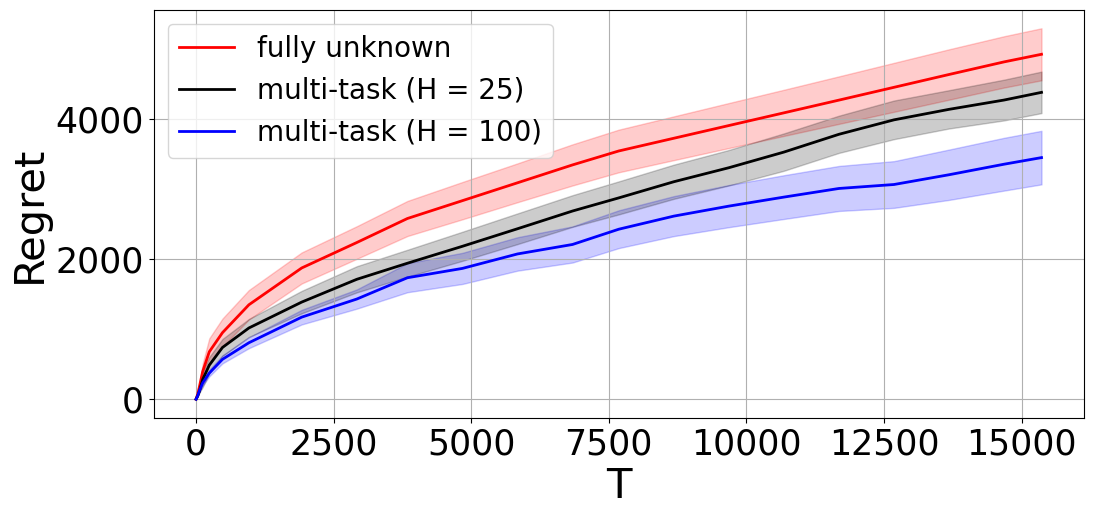

In [43]:
data_1 = regret_multi_H_25
mean_1 = np.mean(data_1, axis=1)
sem_1 = np.std(data_1, axis=1) / np.sqrt(data_1.shape[0])
ci_1 = 0.8*sem_1


data_2 = regret_multi_H_100
mean_2 = np.mean(data_2, axis=1)
sem_2 = np.std(data_2, axis=1) / np.sqrt(data_2.shape[0])
ci_2 = 0.8*sem_2


data_3 = regret_single
mean_3 = np.mean(data_3, axis=1)
sem_3 = np.std(data_3, axis=1) / np.sqrt(data_3.shape[0])
ci_3 = 0.8*sem_3

plt.figure(figsize=(12,6))

# Create a plot
plot_1=plt.plot(times, mean_3,label=f"fully unknown", color='red', linewidth=2)
plot_2=plt.plot(times, mean_1,label=f"multi-task (H = 25)", color='black', linewidth=2)
plot_3=plt.plot(times, mean_2,label=f"multi-task (H = 100)", color='blue', linewidth=2)

fill_1=plt.fill_between(times, mean_3-ci_3, mean_3+ci_3, color='red', alpha=0.2)
fill_2=plt.fill_between(times, mean_1-ci_1, mean_1+ci_1, color='black', alpha=0.2)
fill_3=plt.fill_between(times, mean_2-ci_2, mean_2+ci_2, color='blue', alpha=0.2)


plt.ylabel(r'Regret',fontsize=30)
plt.xlabel('T',fontsize=30)
plt.tick_params(axis='both', labelsize=25)

plt.legend(fontsize="30")
# Exclude the shading elements from the legend
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[:4]  # Keep only the handles for the curve lines
labels = labels[:4]  # Keep only the labels for the curve lines
plt.legend(handles=handles, labels=labels,fontsize=20)
plt.subplots_adjust(bottom=0.20)
plt.grid()

plt.savefig('regret_easily_identifiable.pdf')